<a href="https://colab.research.google.com/github/zahwa001/TA_Zahwa/blob/main/lstm_flood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Based from the tutorial of Jason Brownlee on Recurrent Neural Networks
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from google.colab import files
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.style.use('ggplot')


In [7]:
# fix random seed for reproducibility
np.random.seed(10)

In [71]:
# --- Upload file ---
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

# --- Read CSV ---
try:
    # Try to use 'timestamp' as index if it exists
    df = pd.read_csv(CSV_PATH, parse_dates=['timestamp'], index_col='timestamp')
except (KeyError, ValueError):
    # If 'timestamp' column does not exist, read normally
    df = pd.read_csv(CSV_PATH)

print("✅ File siap:", CSV_PATH)

# --- Inspect data ---
print("\nData awal:")
print(df.head())

# --- Remove rows where 'depth' is 0 ---
initial_rows = len(df)
df = df[df['depth'] != 0]
removed_rows = initial_rows - len(df)
if removed_rows > 0:
    print(f"Removed {removed_rows} rows where 'depth' was 0.")
else:
    print("No rows with 'depth' equal to 0 found.")

# Check timestamp range if exists
if 'timestamp' in df.columns or df.index.name == 'timestamp':
    print("Rentang waktu:", df.index.min(), "→", df.index.max())
else:
    print("Rentang waktu: Tidak ada timestamp")

print("Jumlah baris:", len(df))
print("Missing values:\n", df.isna().sum())

Saving flood_train.csv to flood_train (2).csv
✅ File siap: flood_train (2).csv

Data awal:
                                 device code           device name  \
timestamp                                                            
2025-11-21 23:48:11.682000+00:00       68D08  Alat Pompa Ketintang   
2025-11-21 23:33:11.837000+00:00       68D08  Alat Pompa Ketintang   
2025-11-21 23:18:11.549000+00:00       68D08  Alat Pompa Ketintang   
2025-11-21 23:03:11.637000+00:00       68D08  Alat Pompa Ketintang   
2025-11-21 22:48:11.395000+00:00       68D08  Alat Pompa Ketintang   

                                        location status  waterlevel  rainfall  \
timestamp                                                                       
2025-11-21 23:48:11.682000+00:00  alat ketintang   AMAN      59.534       0.0   
2025-11-21 23:33:11.837000+00:00  alat ketintang   AMAN      59.959       0.0   
2025-11-21 23:18:11.549000+00:00  alat ketintang   AMAN      59.959       0.0   
2025-11-21 23

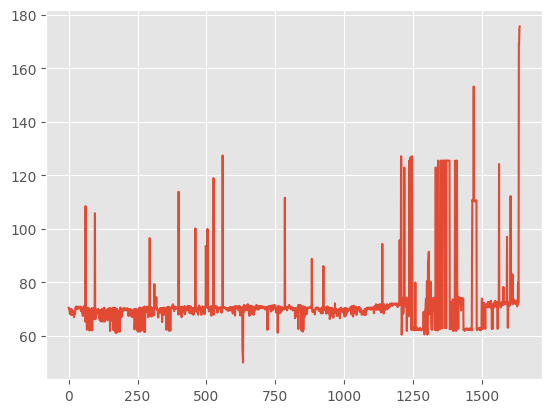

In [72]:
dataset = df['depth'].values.astype('float32')
plt.plot(dataset)

In [73]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [74]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
train, test = dataset[:train_size, :], dataset[train_size:, :]
print(len(train), len(test))

1311 328


----------------- TRAINING DATA -----------------


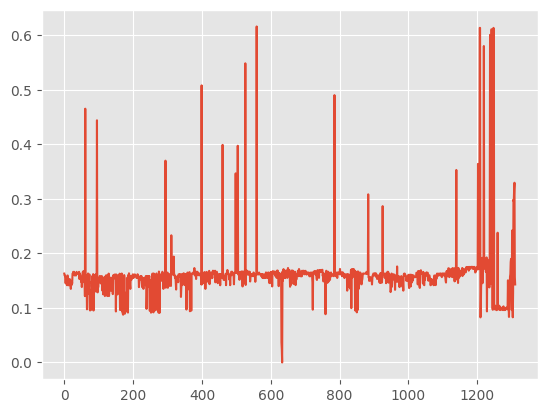

----------------- TEST DATA -----------------


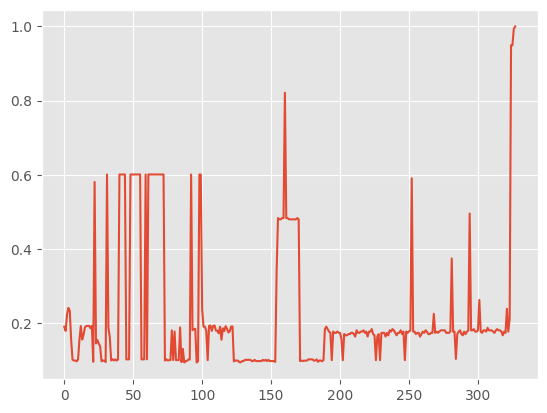

In [75]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

In [76]:
# This function creates a sliding window dataset for multi-step forecasting
def create_dataset(dataset, sliding_window=1, forecast_horizon=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - sliding_window - forecast_horizon + 1):
        # past observations (input)
        past = dataset[i:(i + sliding_window), 0]
        dataX.append(past)

        # future observations (output)
        future = dataset[(i + sliding_window):(i + sliding_window + forecast_horizon), 0]
        dataY.append(future)

    return np.array(dataX), np.array(dataY)

In [77]:
slide_window = 10
forecast_horizon = 96 # Match the Dense layer output
trainX, trainY = create_dataset(train, slide_window, forecast_horizon=forecast_horizon)
testX, testY   = create_dataset(test, slide_window, forecast_horizon=forecast_horizon)

In [78]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [79]:
# Setup the LSTM for multi-step forecasting
model = Sequential()

# LSTM expects input shape = (time_steps, features)
# Corrected: input_shape should be (1, slide_window) to match the reshaped data (samples, 1, slide_window)
model.add(LSTM(64, input_shape=(1, slide_window)))  # 64 units, 1 time step, 10 features
model.add(Dense(96))  # output 96 steps (24 hours ahead at 15-min intervals)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=70, batch_size=32, verbose=2)

Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 29ms/step - loss: 0.0167
Epoch 2/70
38/38 - 0s - 5ms/step - loss: 0.0030
Epoch 3/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 4/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 5/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 6/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 7/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 8/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 9/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 10/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 11/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 12/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 13/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 14/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 15/70
38/38 - 0s - 8ms/step - loss: 0.0025
Epoch 16/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 17/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 18/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 19/70
38/38 - 0s - 5ms/step - loss: 0.0025
Epoch 20/70
38/38 - 0s - 4ms/step - loss: 0.0025
Epoch 21/70
38/38 - 0s - 5ms/step - los

In [80]:
# make predictions
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

# invert scaling (keep 2D shape: samples × forecast_horizon)
trainPredict_inv = scaler.inverse_transform(trainPredict)
trainY_inv       = scaler.inverse_transform(trainY)
testPredict_inv  = scaler.inverse_transform(testPredict)
testY_inv        = scaler.inverse_transform(testY)

# calculate RMSE across all forecast steps
trainScore = math.sqrt(mean_squared_error(trainY_inv.flatten(), trainPredict_inv.flatten()))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inv.flatten(), testPredict_inv.flatten()))
print('Test Score: %.2f RMSE' % (testScore))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Score: 6.17 RMSE
Test Score: 20.41 RMSE


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


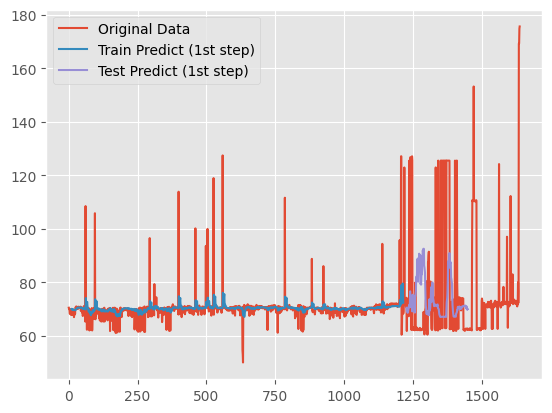

In [81]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

# invert predictions
trainPredict_inv = scaler.inverse_transform(trainPredict)
trainY_plot = scaler.inverse_transform(trainY[:, 0].reshape(-1,1)) # Take the first predicted step's true value
testPredict_inv  = scaler.inverse_transform(testPredict)
testY_plot = scaler.inverse_transform(testY[:, 0].reshape(-1,1)) # Take the first predicted step's true value

# For plotting, use only the first predicted step from the multi-step output
trainPredict_single_step = trainPredict_inv[:, 0].reshape(-1, 1)
testPredict_single_step  = testPredict_inv[:, 0].reshape(-1, 1)

# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict_single_step)+slide_window, :] = trainPredict_single_step

# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan

testPredictPlot[test_plot_start_idx : test_plot_start_idx + len(testPredict_single_step), :] = testPredict_single_step

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predict (1st step)')
plt.plot(testPredictPlot, label='Test Predict (1st step)')
plt.legend()
plt.show()

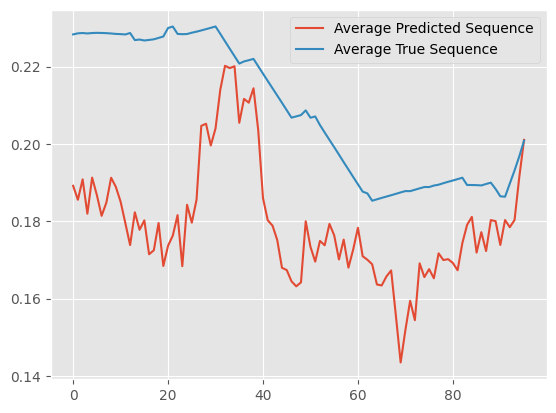

In [82]:
# average across all samples
plt.plot(testPredict.mean(axis=0), label='Average Predicted Sequence')
plt.plot(testY.mean(axis=0), label='Average True Sequence')
plt.legend()
plt.show()

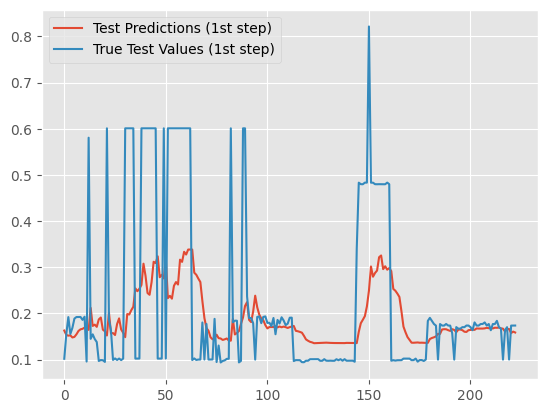

In [83]:
# plot only the first forecast step
plt.plot(testPredict[:, 0], label='Test Predictions (1st step)')
plt.plot(testY[:, 0], label='True Test Values (1st step)')
plt.legend()
plt.show()

In [ ]:
!pip install flask-ngrok

In [1]:
!pip install flask-ngrok

In [5]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Starts ngrok automatically

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    # Suppose your AI model code here
    result = {"output": data["input"] * 2}  # example
    return jsonify(result)

app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
            

In [4]:
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()

class Item(BaseModel):
    input: float

@app.post("/predict")
def predict(item: Item):
    return {"output": item.input * 2}
